## Generate white noise stimuli
Run in unityvr virtual environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk, rectangle
from scipy.signal import convolve2d
from pathlib import Path
from os.path import sep
import scipy as sp
import imageio
import pandas as pd
import json

np.random.seed(seed=3)
%config Completer.use_jedi = False  #magic to fix autocomplete issue
%matplotlib inline

from stimGen import generateSingleSpotPan, plotPanorama, plotPanoramaStretch, createMovie

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

### Visibility range of the screen
#### (a) Visibility above the horizon line
This visibility range is limited by either the fly holder (pyramid) or the screen height. 
If the screen is limited, the angle it spans depends on the screen distance  which may vary along the azimuth. We will consider only the extreme values, i.e. the minimum and maximum screen distances. For the pentagonal screen that's r_min at the center of the faces and r_max at the corners. 

In [2]:
screenMinDist = 4.0 #cm (r_min in Fig1 S1)
screenMaxDist = 5.5 #cm (r_max in Fig1 S1)

topScreenHeight = 2.5 #cm
bottomScreenHeight = 7 #cm

alpha_rmin = (180/np.pi) * np.arctan( topScreenHeight / screenMinDist)
alpha_rmax = (180/np.pi) * np.arctan( topScreenHeight / screenMaxDist)

print("The screen spans an angle from {} to {} above the horizon line.".format(alpha_rmax, alpha_rmin))

The screen spans an angle from 24.443954780416536 to 32.005383208083494 above the horizon line.


#### (b) Visibility below the horizon line
This visibility range is limited by the ball surface (unless the screen is very short). Set `no_ball` to be true if screen limited.

In [3]:
no_ball = False

In [4]:
if not no_ball:
    ballRad = 4.65 # treadmill ball radius [mm]
    flyEyeAboveBall = 1 # height of eye above ball surface [mm]
    
    print('Angle visible below horizon line:',90-(180/np.pi)*np.arcsin(ballRad/(flyEyeAboveBall+ballRad)))
else:
    beta_rmin = (180/np.pi) * np.arctan( bottomScreenHeight / screenMinDist)
    beta_rmax = (180/np.pi) * np.arctan( bottomScreenHeight / screenMaxDist)
    print("The screen spans an angle from {} to {} below the horizon line.".format(beta_rmax, beta_rmin))

Angle visible below horizon line: 34.61286464893424


### Determine appropriate size for the texture
Choose which angle should be spanned. The texture will be sized to be displayed such that it spans the full size at the closest points on the  screen (r_min). Thus, the texture should be displayed on a cylinder with radius r_min.

In [5]:
RFmapCylinder = True

In [6]:

setalpha = alpha_rmin*(np.pi/180) if not no_ball else np.max([beta_rmin,alpha_rmin])*(np.pi/180)
if RFmapCylinder:
    height_cm = 7
else:
    height_cm = np.round(np.tan(setalpha) * screenMinDist, 2) * 2
# Values to set in unity scene:
print('Cylinder height: {} cm, Cylinder radius: {} cm'.format(height_cm/2, screenMinDist))

Cylinder height: 3.5 cm, Cylinder radius: 4.0 cm


In [7]:
singleScreenResolution = [720,480] # pixels, check what the projector res is set to on the computer

## calculating pixel/cm based on the minimal allowed resolution so that the full resolution of the panorama can be used
##  TODO: check if this is correct (calculation based on circle to line projection)
pt_per_cm = np.max([1/(((2*np.sqrt(screenMaxDist**2-screenMinDist**2))/singleScreenResolution[1])*(1/(1+(screenMaxDist/screenMinDist)**2))), 
                    singleScreenResolution[0]/(topScreenHeight+bottomScreenHeight)])

panHeight_px = int(height_cm * pt_per_cm)
panWidth_px = int(2*np.pi*screenMinDist*pt_per_cm)

maxBit = 255 #assuming 8bit image depth
print("pixels along elevation:",panHeight_px)
print("pixels along azimuth:",panWidth_px)

pixels along elevation: 1286
pixels along azimuth: 4618


## Create random noise vector

In [8]:
barSizeAng = 5 #deg
barRad = int(panWidth_px * 0.5 * (barSizeAng/360))

In [9]:
def oneDGrating(panWidth_px, barRad, maxBit = 255, randomVector=None, thresh = 0.97):
    oneD = np.zeros(panWidth_px)
    if randomVector is None:
        np.random.seed(seed=randomVector)
        randomVector = np.random.rand(len(oneD))
    #oneD[randomVector>(thresh)] = 1
    oneD[randomVector<(1-thresh)] = 1
    
    kernel = np.ones(barRad)*maxBit
    return sp.signal.convolve(oneD, kernel, mode='same')#*maxBit/2+maxBit/2

## Convert to 2D and Rotate

In [10]:
def twoDNoise(panWidth_px, panHeight_px, barRad, thresh = 1-1/1000, maxBit = 255, randomVector = None, Nframes=1):
    pan = np.zeros((panWidth_px,panHeight_px),dtype=np.uint8)
    if randomVector is None:
        np.random.seed(seed=randomVector)
        randomVector = np.random.rand(panWidth_px)
    
    for i in range(pan.shape[1]):
        pan[:,i] = oneDGrating(panWidth_px=panWidth_px, maxBit = maxBit, barRad=barRad, thresh=thresh, randomVector=randomVector)

    return maxBit-pan

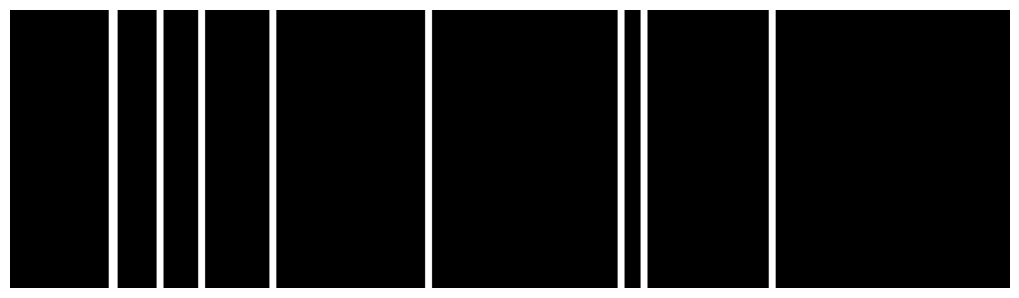

In [11]:
fig = plotPanorama(twoDNoise(panWidth_px,panHeight_px,barRad),panHeight_px,panWidth_px,maxBit)

## Convert to Movie

Generate velocity time series for on-axis movement. 

In [ ]:
fps = 4 #/sec
maxTime = 30 #min
threshRes = 2000
thresh = 1-1/threshRes

Nframes = int(round(maxTime*60*fps))
print("number of frames: ",Nframes)

number of frames:  7200


In [13]:
seed = 3

In [14]:
time = np.linspace(0,maxTime*60,Nframes) #seconds
np.random.seed(seed=seed)
movieStackRands = np.random.rand(Nframes,panWidth_px)

In [15]:
movieStack = np.zeros((Nframes,panWidth_px,panHeight_px),dtype=np.uint8)
for i in range(Nframes):
    randomVector = movieStackRands[i]
    movieStack[i] = twoDNoise(panWidth_px,panHeight_px, barRad = barRad, thresh = thresh, randomVector = randomVector)

In [16]:
%%capture
anim = createMovie(movieStack,panHeight_px,panWidth_px,maxBit)

In [17]:
from IPython.display import HTML
HTML(anim.to_jshtml())
# Save the animation as an MP4 file

## Save movie as a series of images

In [18]:
video_name = "1DWhiteNoise"+"_threshRes-"+str(threshRes)+"_barSize-"+str(
    barSizeAng)+"_fps-"+str(fps)+"_"+str(maxTime)+"-min"+"_seed-"+str(seed)

In [19]:
Path(sep.join(["movies",video_name])).mkdir(parents=True, exist_ok=True)

In [20]:
stimGenDf = pd.DataFrame(np.arange(0,Nframes),columns=['sceneID'])
stimGenDf['expectedTime'] = time
stimGenDf['filename'] = (stimGenDf['sceneID']+1).astype('str').str[:]+'.png'
stimGenDf.to_csv(sep.join(["movies",video_name,'stimGenDf.csv']))

np.save(sep.join(["movies",video_name,'scene1DArray.npy']),movieStack[:,:,0])

In [21]:
extendFrac = 1.2 #to account for dropped frames in unity

In [22]:
textures = []
for i in range(len(stimGenDf)):
    imageio.imwrite(sep.join(["movies",video_name,stimGenDf.iloc[i]['filename']]), maxBit-movieStack[i,:,:].T)
    textures.append(stimGenDf.iloc[i]['filename'])

temp = {
    'durationSecs': (1 / fps)*extendFrac,
    'textures': textures,
    'separatorDurationSecs': 0,
}
json_name = sep.join(["movies",video_name,'start.json'])
with open(json_name, 'w') as json_file:
    json_file.write(json.dumps(temp))

In [23]:
anim.save(sep.join(["movies",video_name,'video.mp4']), writer='ffmpeg', fps=5)

## Generate reshaped movies

# TODO 

In [52]:
import pandas as pd
from scipy.optimize import minimize
import scipy as sp

Dir = 'screenMeasurements/' #"/Volumes/jayaramanlab/Shivam/" #connect to dm11
rig = "Hannah" #"Shivam"#

if rig == "Shivam":
    file2 = rig+"Rig_mean_brightness_level_6.csv"
else:
    file2 = rig+"Rig_mean_brightness.csv"
    
file = rig+"Rig_lookup_table_transformed_brightness.csv"

lookupDf = pd.read_csv(Dir+file)
mean_brightness = pd.read_csv(Dir+file2)

In [53]:
def rescale(img):
    x = img.flatten()
    y = np.array(lookupDf.iloc[x]['Iin'])
    imgT = y.reshape(np.shape(img))
    return imgT

def simulateI(img):
    x = img.flatten()
    y = np.array(transformDf.iloc[x]['Iin'])
    imgT = y.reshape(np.shape(img))
    return imgT

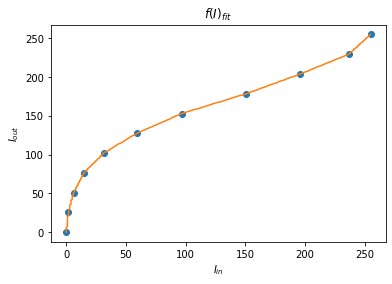

In [54]:
y = np.array(mean_brightness['I'].values)
x = np.arange(0,256,1)
y = np.zeros(x.shape)

b = sp.interpolate.interp1d(mean_brightness['I'], mean_brightness['Stim'],bounds_error=False)

def diff(x,a):
    yt = b(x)
    return (yt - a)**2

for idx,x_value in enumerate(x):
    res = minimize(diff, 1.0, args=(x_value), method='Nelder-Mead', tol=1e-6)
    y[idx] = res.x[0]

plt.plot(mean_brightness['I'].values,mean_brightness['Stim'].values,'o');
plt.plot(np.round(y).astype('int'),x)
plt.title(r'$f(I)_{fit}$')
plt.ylabel("$I_{out}$"); plt.xlabel("$I_{in}$");

transformDf = pd.DataFrame(np.array([np.round(y).astype('int'),x]).T, columns = ["Iin", "Iout"])

**Generate and save simulated original gradients**

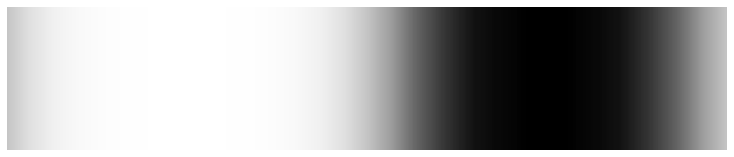

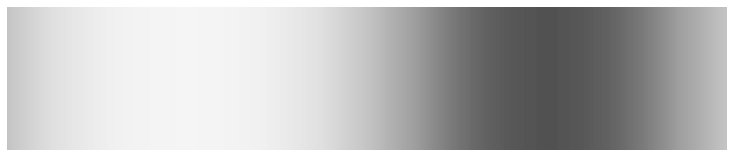

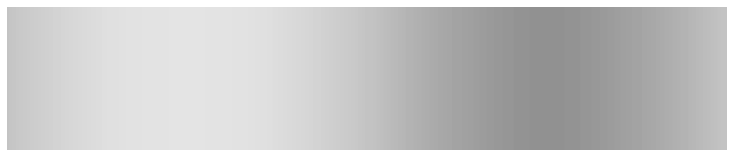

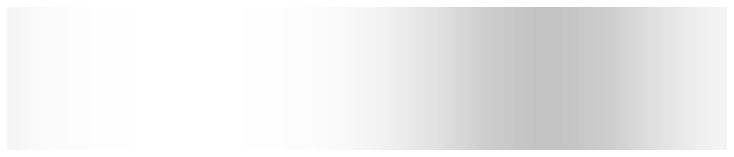

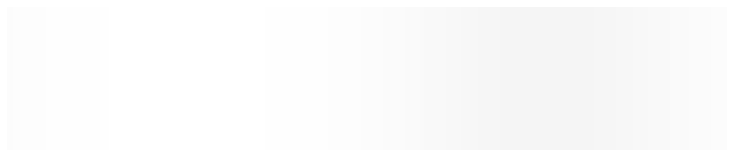

In [55]:
# make directory if it does not already exist
Path("panoramas/simulated").mkdir(parents=True, exist_ok=True)

fig = plotPanorama(simulateI(panGrad).T,panHeight_px,panWidth_px, maxBit)
fig.savefig("panoramas"+sep+'simulated'+sep+"C1_gradient_simulated_{}Rig.png".format(rig),dpi = dpiVal)

fig = plotPanorama(simulateI(panGradLow).T,panHeight_px,panWidth_px, maxBit)
fig.savefig("panoramas"+sep+"simulated"+sep+"C2_gradientLow_simulated_{}Rig.png".format(rig),dpi = dpiVal)

fig = plotPanorama(simulateI(panGradVeryLow).T,panHeight_px,panWidth_px, maxBit)
fig.savefig("panoramas"+sep+"simulated"+sep+"C3_gradientVeryLow_simulated_{}Rig.png".format(rig),dpi = dpiVal)

fig = plotPanorama(simulateI(panGradLowBright).T,panHeight_px,panWidth_px, maxBit)
fig.savefig("panoramas"+sep+"simulated"+sep+"C4_gradientLowBright_simulated_{}Rig.png".format(rig),dpi = dpiVal)

fig = plotPanorama(simulateI(panGradVeryLowBright).T,panHeight_px,panWidth_px, maxBit)
fig.savefig("panoramas"+sep+"simulated"+sep+"C5_gradientVeryLowBright_simulated_{}Rig.png".format(rig),dpi = dpiVal)

**Generate and save reshaped gradients**

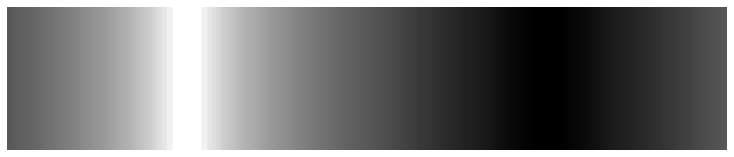

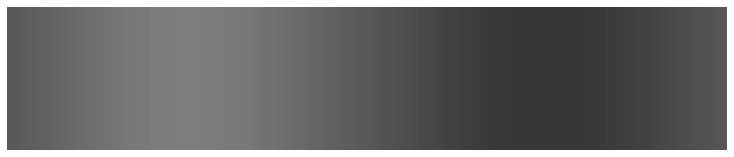

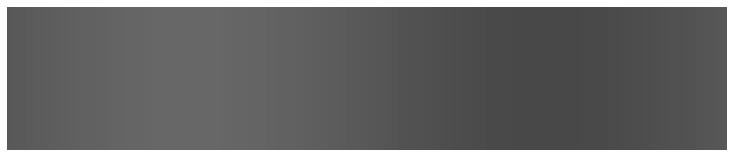

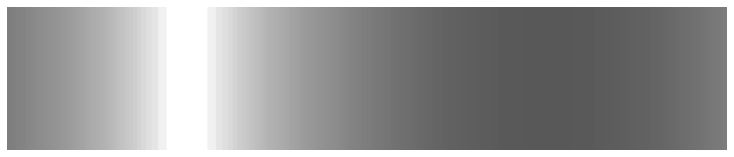

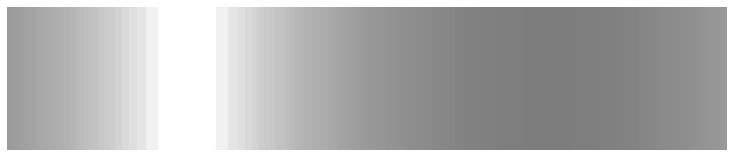

In [56]:
# make directory if it does not already exist
Path("panoramas/reshaped").mkdir(parents=True, exist_ok=True)

fig = plotPanorama(rescale(panGrad).T,panHeight_px,panWidth_px, maxBit)
fig.savefig("panoramas"+sep+"reshaped"+sep+"C1_gradient_reshaped_{}Rig.png".format(rig),dpi = dpiVal)

fig = plotPanorama(rescale(panGradLow).T,panHeight_px,panWidth_px, maxBit)
fig.savefig("panoramas"+sep+"reshaped"+sep+"C2_gradientLow_reshaped_{}Rig.png".format(rig),dpi = dpiVal)

fig = plotPanorama(rescale(panGradVeryLow).T,panHeight_px,panWidth_px, maxBit)
fig.savefig("panoramas"+sep+"reshaped"+sep+"C3_gradientVeryLow_reshaped_{}Rig.png".format(rig),dpi = dpiVal)

fig = plotPanorama(rescale(panGradLowBright).T,panHeight_px,panWidth_px, maxBit)
fig.savefig("panoramas"+sep+"reshaped"+sep+"C4_gradientLowBright_reshaped_{}Rig.png".format(rig),dpi = dpiVal)

fig = plotPanorama(rescale(panGradVeryLowBright).T,panHeight_px,panWidth_px, maxBit)
fig.savefig("panoramas"+sep+"reshaped"+sep+"C5_gradientVeryLowBright_reshaped_{}Rig.png".format(rig),dpi = dpiVal)

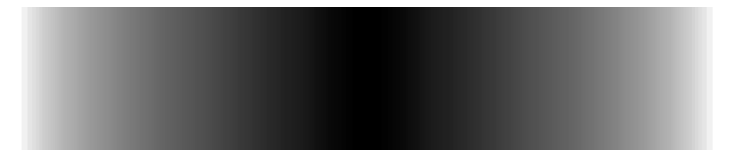

In [57]:
fig = plotPanorama(np.roll(rescale(panGrad).T, -int(np.shape(pan)[0]/4), axis = 0), panHeight_px,panWidth_px,maxBit) #)
fig.savefig("panoramas"+sep+"reshaped"+sep+"C1_gradient_reshaped_{}RigLeftShifted.png".format(rig),dpi = dpiVal)

#### Reshape gradients with sundisk

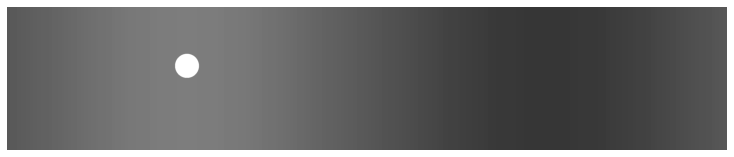

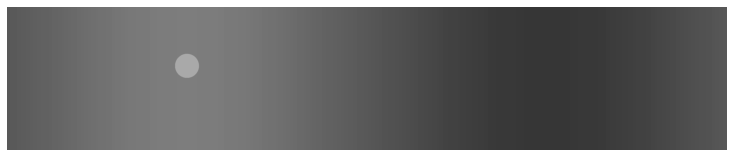

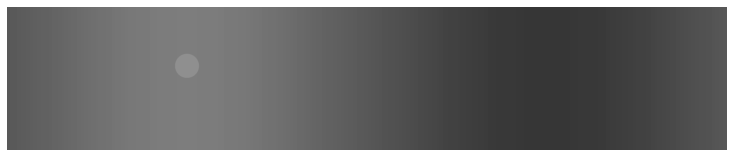

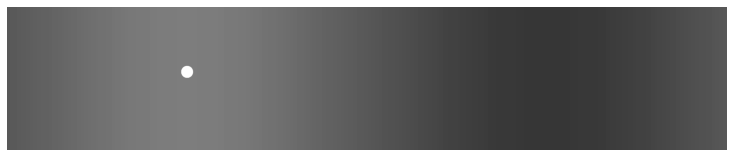

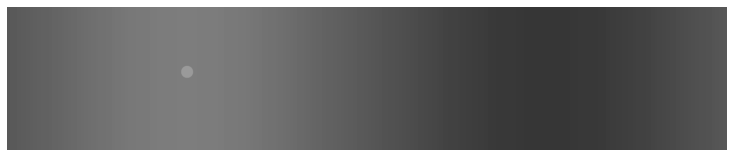

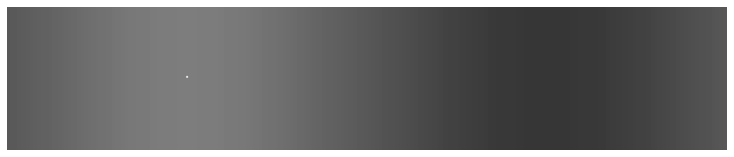

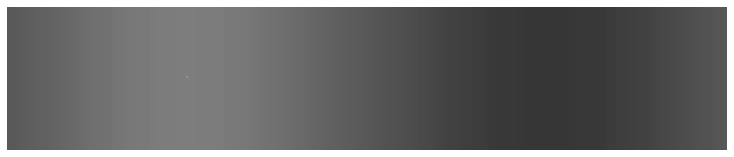

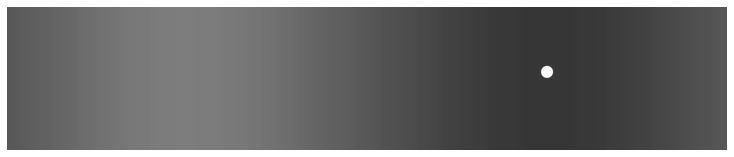

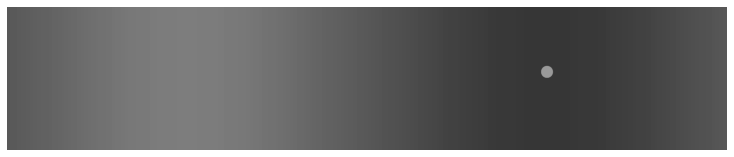

In [58]:
panLeftShifted = np.roll(pan12, -int(np.shape(pan)[0]/4), axis = 0)
brightStr = np.array(["High","Mid","Low"])

brightRange = np.linspace(0,np.min(panGradLow),len(brightStr)+1)
for i,bStr in enumerate(brightStr):
    spotBrightness = brightRange[i]
    panSpotGradLow = np.where(panLeftShifted.T>0,spotBrightness,panGradLow)
    fig = plotPanorama(rescale(panSpotGradLow.T),panHeight_px,panWidth_px, maxBit)
    fig.savefig("panoramas"+sep+"reshaped"+sep+"C2"+"S"+str(i+1)+"_panoramaSpot"+bStr+"GradientLow_reshaped_{}Rig.png".format(rig),dpi = dpiVal)
    
panLeftShifted = np.roll(pan6, -int(np.shape(pan)[0]/4), axis = 0)
brightStr = np.array(["High","Low"])

brightRange = np.linspace(0,np.min(panGradLow),len(brightStr)+1)
for i,bStr in enumerate(brightStr):
    spotBrightness = brightRange[i]
    panSpotGradLow = np.where(panLeftShifted.T>0,spotBrightness,panGradLow)
    fig = plotPanorama(rescale(panSpotGradLow.T),panHeight_px,panWidth_px, maxBit)
    fig.savefig("panoramas"+sep+"reshaped"+sep+"C2"+"S"+str(i+1)+"s_panoramaSpot"+bStr+"GradientLow_reshaped_{}Rig.png".format(rig),dpi = dpiVal)

    
panLeftShifted = np.roll(pan1, -int(np.shape(pan)[0]/4), axis = 0)
brightStr = np.array(["High","Low"])

brightRange = np.linspace(0,np.min(panGradLow),len(brightStr)+1)
for i,bStr in enumerate(brightStr):
    spotBrightness = brightRange[i]
    panSpotGradLow = np.where(panLeftShifted.T>0,spotBrightness,panGradLow)
    fig = plotPanorama(rescale(panSpotGradLow.T),panHeight_px,panWidth_px, maxBit)
    fig.savefig("panoramas"+sep+"reshaped"+sep+"C2"+"S"+str(i+1)+"ss_panoramaSpot"+bStr+"GradientLow_reshaped_{}Rig.png".format(rig),dpi = dpiVal)
    
panRightShifted = np.roll(pan6, +int(np.shape(pan)[0]/4), axis = 0)
brightStr = np.array(["High","Low"])

brightRange = np.linspace(0,np.min(panGradLow),len(brightStr)+1)
for i,bStr in enumerate(brightStr):
    spotBrightness = brightRange[i]
    panSpotGradLow = np.where(panRightShifted.T>0,spotBrightness,panGradLow)
    fig = plotPanorama(rescale(panSpotGradLow.T),panHeight_px,panWidth_px, maxBit)
    fig.savefig("panoramas"+sep+"reshaped"+sep+"C2"+"T"+str(i+1)+"ss_panoramaSpot"+bStr+"GradientLow_reshaped_{}Rig.png".format(rig),dpi = dpiVal)

#### Reshape double sun stimuli

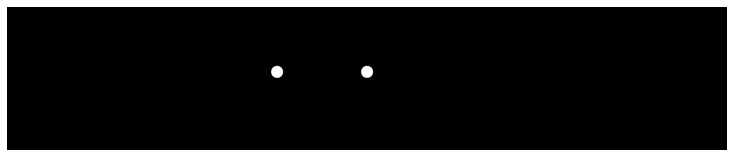

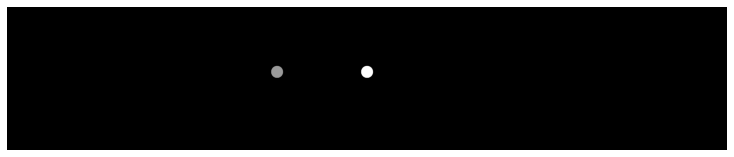

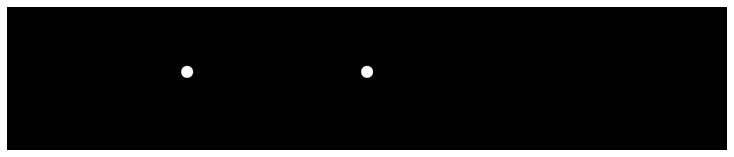

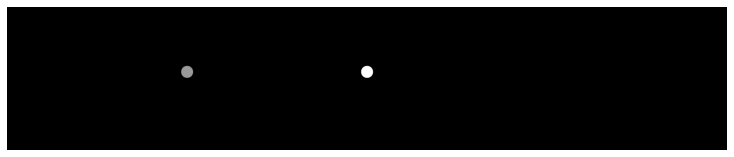

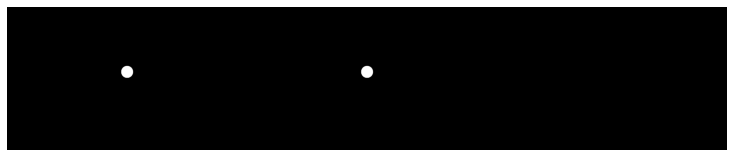

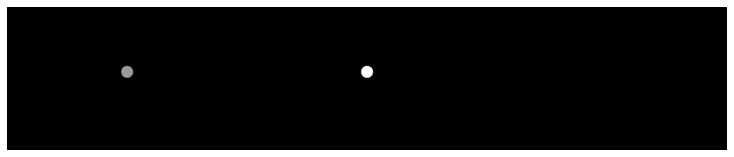

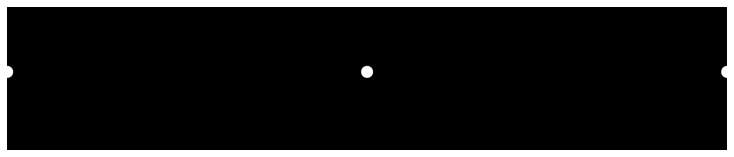

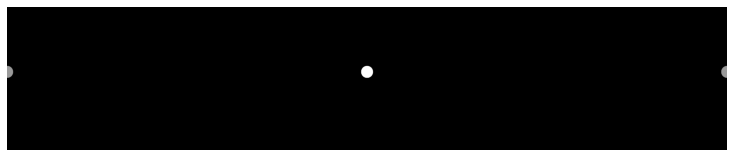

In [59]:
sepStr = ['45','90','120','180']
brightStr = np.array(["High","Low"])
for j,sStr in enumerate(sepStr):
    panLeftShifted = np.roll(pan6Shifted, -int(sepRange[j]), axis = 0)
    for i,bStr in enumerate(brightStr):
        spotBrightness = brightRange[i]
        panSpotSpotLow = np.where(panLeftShifted.T>0,spotBrightness,brightSpotShifted.T)
        fig = plotPanorama(rescale(panSpotSpotLow.T),panHeight_px,panWidth_px, maxBit)
        fig.savefig("panoramas"+sep+"reshaped"+sep+"A2s"+"D"+str(i+1)+"_"+sStr+"_panoramaSpot"+bStr+"BrightSpot_reshaped_{}Rig.png".format(rig),dpi = dpiVal)

#### Reshape receptive field mapping stimuli

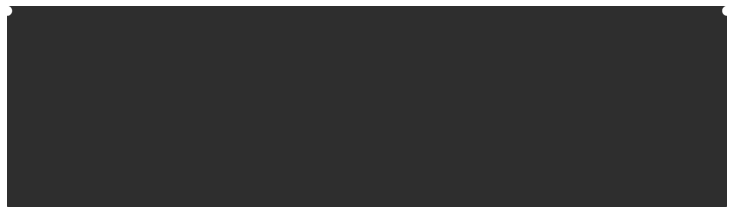

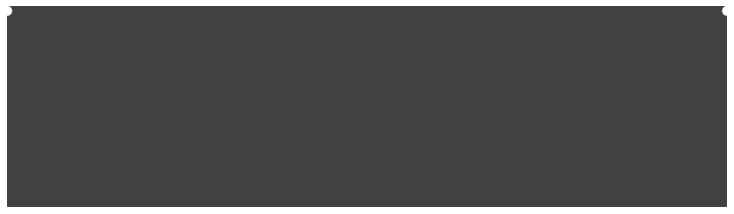

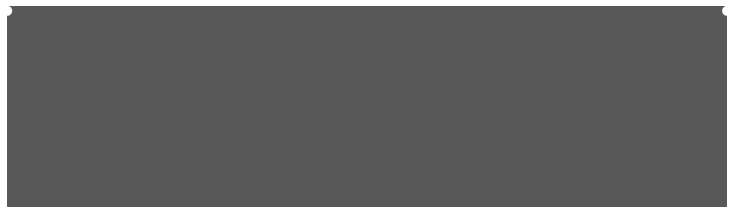

In [60]:
RFpans = [brightSpot_shift1, brightSpot_shift2, brightSpot_shift3]
panName = ['RF2a_brightSpotDGrey','RF2b_brightSpotMGrey','RF2c_brightSpotLGrey']
for i,RFpan in enumerate(RFpans):
    fig = plotPanorama(rescale(RFpan),RFpanHeight_px,RFpanWidth_px, maxBit)
    fig.savefig("panoramas"+sep+"reshaped"+sep+panName[i]+"_reshaped_{}Rig.png".format(rig),dpi = RFdpiVal)

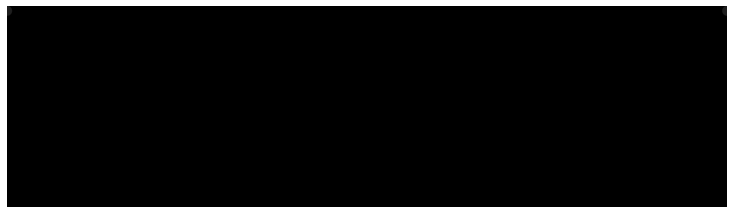

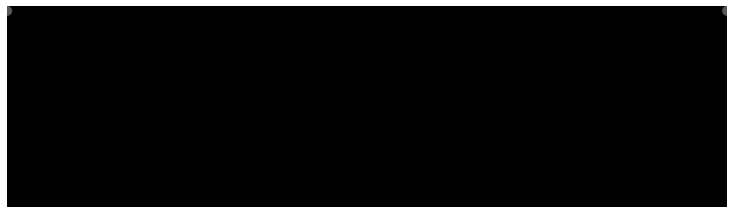

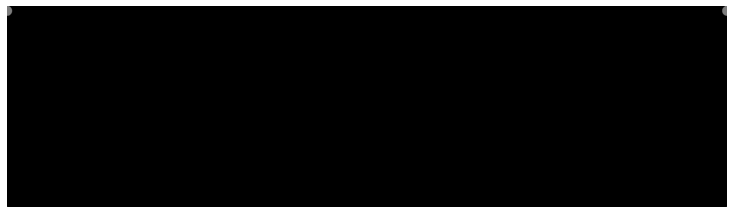

In [61]:
RFpans = [brightSpot_dim1, brightSpot_dim2, brightSpot_dim3]
panName = ['RF3a_dGreySpot','RF3b_mGreySpot','RF3c_lGreySpot']
for i,RFpan in enumerate(RFpans):
    fig = plotPanorama(rescale(RFpan),RFpanHeight_px,RFpanWidth_px, maxBit)
    fig.savefig("panoramas"+sep+"reshaped"+sep+panName[i]+"_reshaped_{}Rig.png".format(rig),dpi = RFdpiVal)

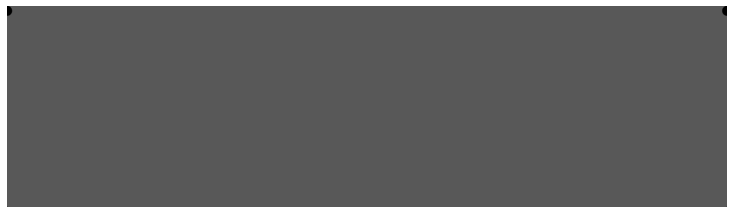

In [62]:
fig = plotPanorama(rescale(darkSpot_shift),RFpanHeight_px,RFpanWidth_px, maxBit)
fig.savefig("panoramas"+sep+"reshaped"+sep+"RF1c_darkSpotLGrey_reshaped_{}Rig.png".format(rig),dpi = RFdpiVal)

#### Reshape sundisk on grey

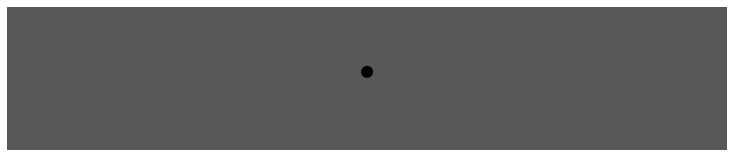

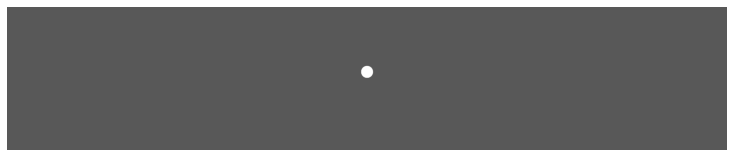

In [63]:
darkSpot = pan6[:,:]
brightSpot = abs(maxBit - darkSpot)

panOn = darkSpot
panOff = maxBit-panOn
panOn = np.minimum(maxBit, panOn)
panOff = np.minimum(maxBit, panOff)

dotRatio = np.sum(panOn/maxBit)/(panWidth_px*panHeight_px)
panOn_shift = panOn/2 + (0.5-dotRatio*0.5)*maxBit
panOff_shift = panOff/2

fig = plotPanorama(rescale(panOn_shift),panHeight_px,panWidth_px, maxBit)
fig.savefig("panoramas"+sep+"reshaped"+sep+"B1s_smallDarkOnGrey_reshaped_{}Rig.png".format(rig),dpi = dpiVal)

fig = plotPanorama(rescale(panOff_shift),panHeight_px,panWidth_px, maxBit)
fig.savefig("panoramas"+sep+"reshaped"+sep+"B2s_smallBrightOnGrey_reshaped_{}Rig.png".format(rig),dpi = dpiVal)

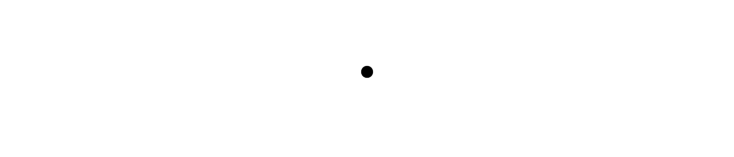

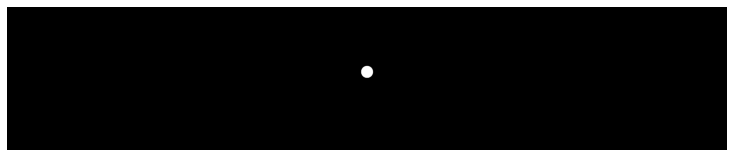

In [64]:
pan6 = generateSingleSpotPan(dotSizeAng=6, 
                            relDotpos=(panWidth_px/2, (panHeight_px + panWidth_px * (6/360) ) /2), 
                            panHeight_px=panHeight_px, panWidth_px=panWidth_px)
darkSpot = pan6[:,:]
brightSpot = abs(maxBit - darkSpot)

fig = plotPanorama(darkSpot,panHeight_px,panWidth_px, maxBit)
fig.savefig("panoramas"+sep+"A1s_smallDarkSpot.png",dpi = dpiVal)

fig = plotPanorama(brightSpot,panHeight_px,panWidth_px, maxBit)
fig.savefig("panoramas"+sep+"A2s_smallBrightSpot.png", dpi = dpiVal)